In [127]:
# импортируем необходимые библиотеки, классы, функции
import pandas as pd
import numpy as np
import math
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from etna.datasets.tsdataset import TSDataset
from etna.transforms import (MeanTransform, 
                             LagTransform, 
                             LogTransform,
                             MeanSegmentEncoderTransform,
                             SegmentEncoderTransform,
                             DateFlagsTransform, 
                             LinearTrendTransform)

from etna.models import (CatBoostModelMultiSegment, 
                         CatBoostModelPerSegment)
from etna.metrics import SMAPE
from etna.analysis import plot_forecast

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression

# увеличиваем количество отображаемых столбцов
pd.set_option('display.max_columns', 300)

# отключаем экспоненциальное представление
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

In [128]:
# загружаем исторические данные продаж
data = pd.read_csv('Data/advert/sales_train.csv', 
                   index_col=['date'], 
                   parse_dates=['date'])

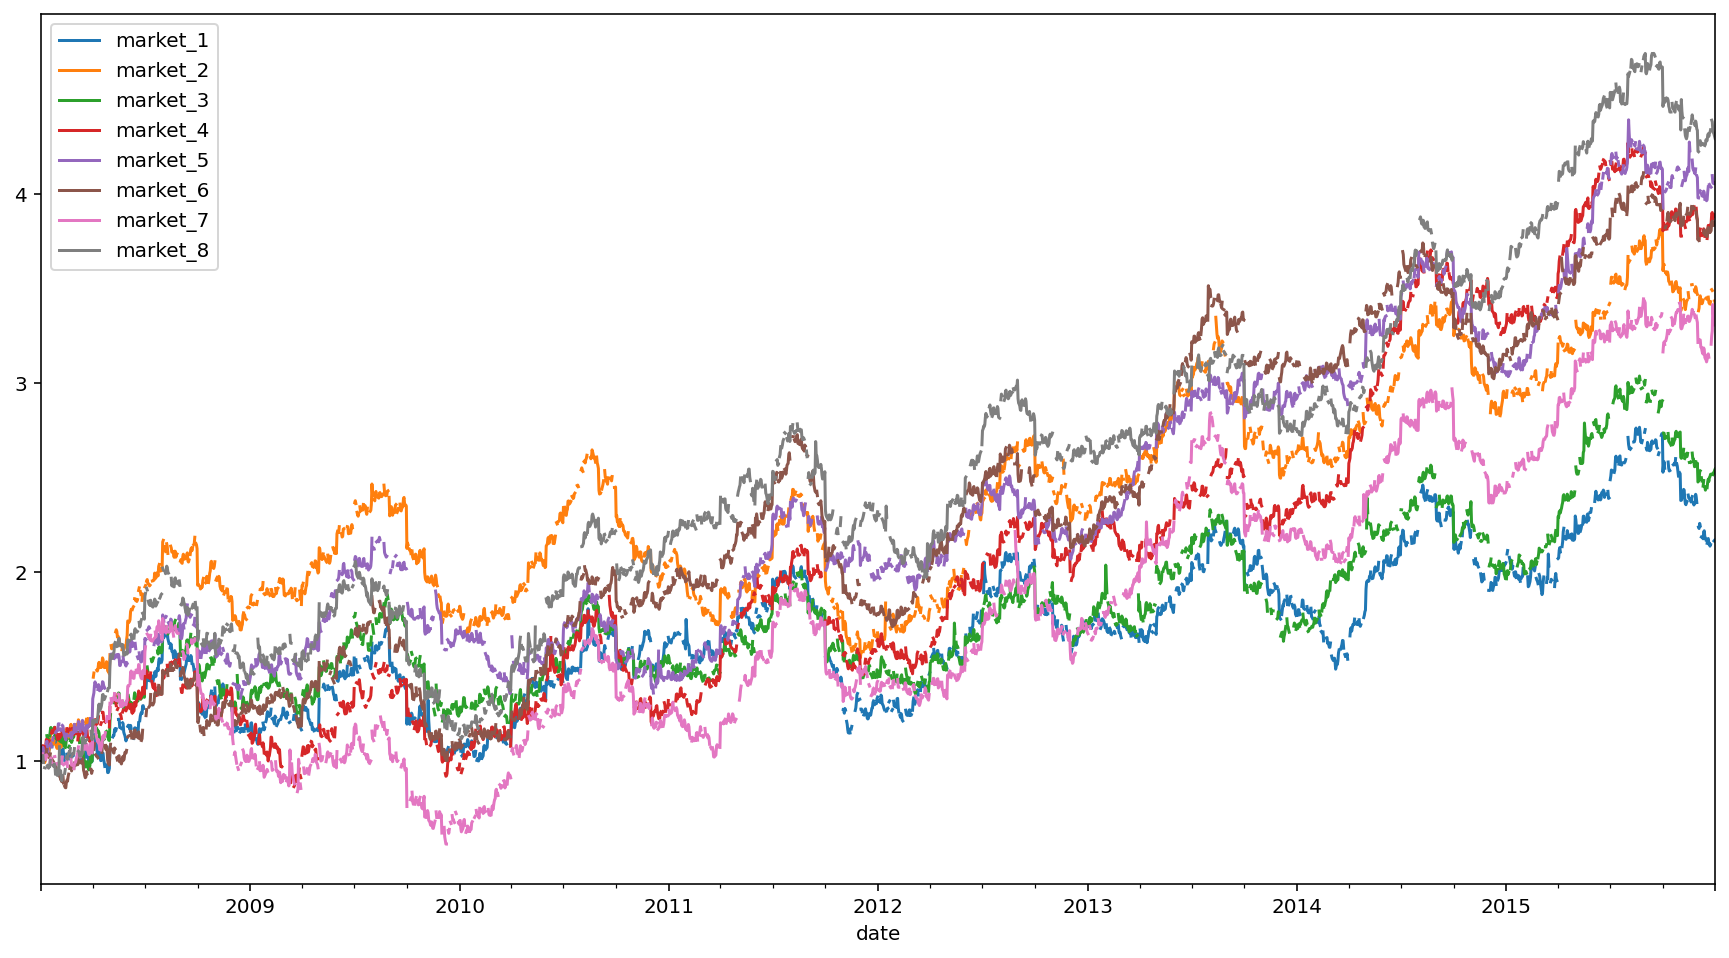

In [129]:
# визуализируем временные ряды продаж
data.plot(figsize=(15, 8));

In [130]:
# заполним пропуски в рядах с помощью линейной интерполяции 
for i in data.columns:
    data[i] = data[i].interpolate(method='linear')

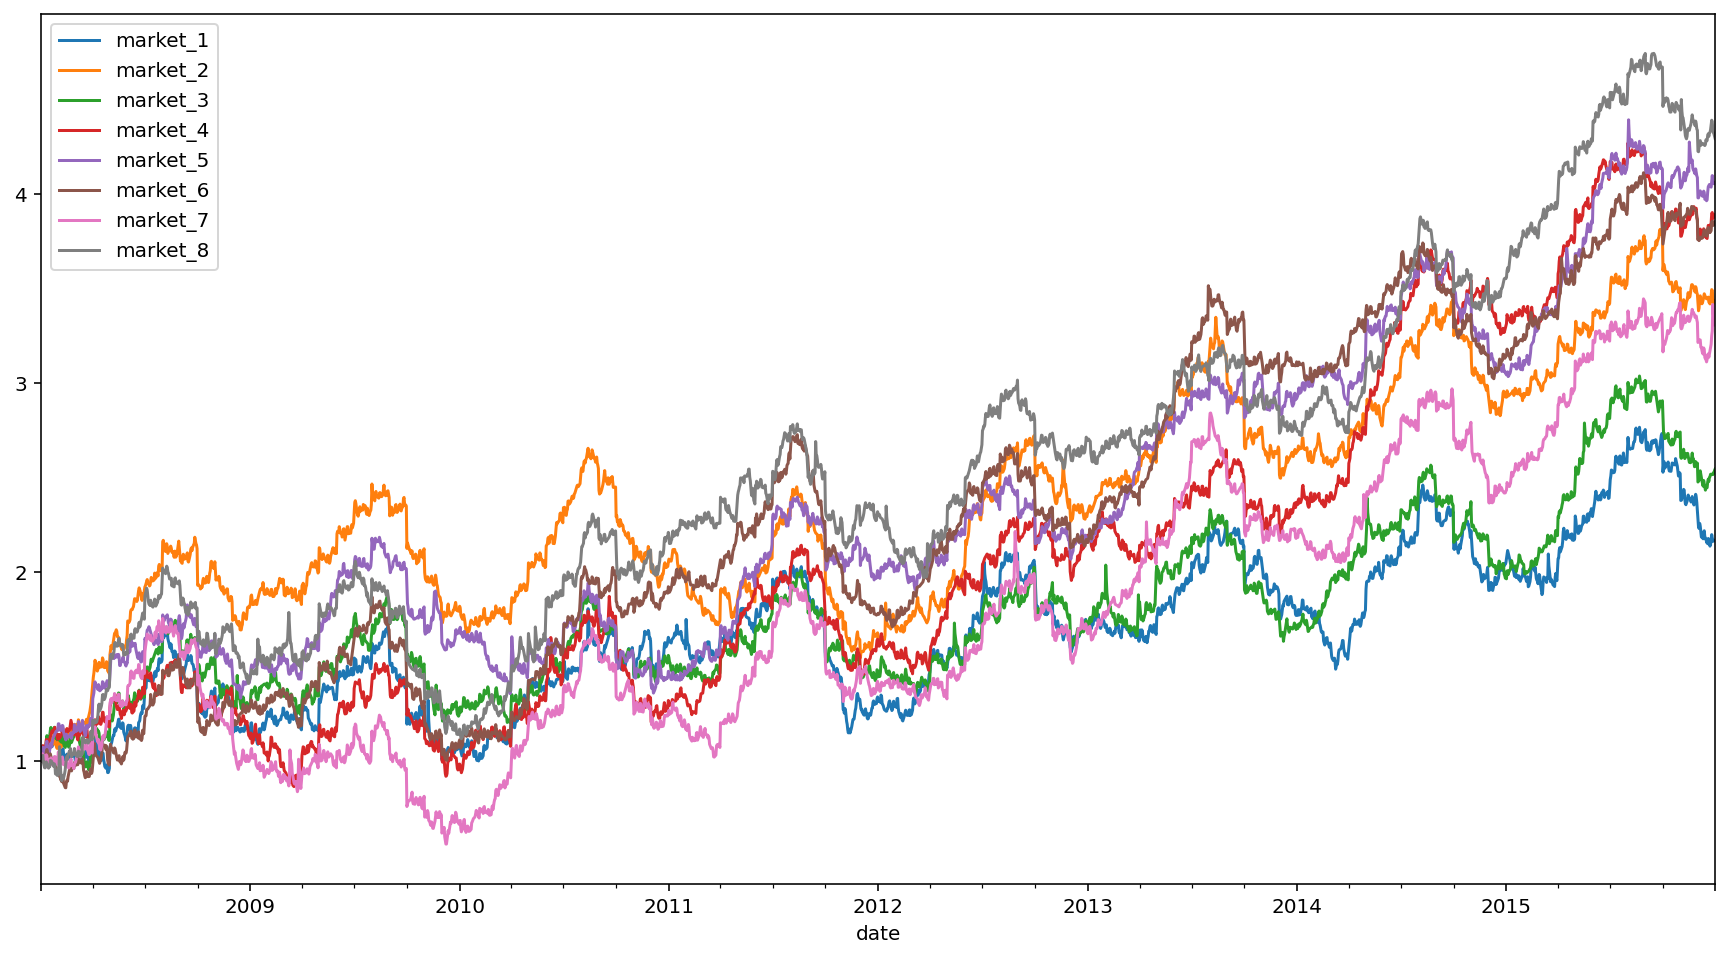

In [131]:
# визуализируем временные ряды
# после заполнения пропусков
data.plot(figsize=(15, 8));

In [132]:
# приведем столбцы датафрейма к формату Multiindex
# это нужно для удобства обращения по отдельности к каждому 
# сегменту (к признакам и зависимой переменной сегмента)
idx = data.columns.to_frame()
idx.insert(1, 'target', 'target')
data.columns = pd.MultiIndex.from_frame(idx)
# смотрим первые 5 наблюдений получившегося датафрейма
data.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
date,,,,,,,,
2008-01-02,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
2008-01-03,1.00759,1.00694,1.00259,1.00695,1.01482,1.01275,1.00899,1.00324
2008-01-04,1.01519,1.02601,1.04354,1.04451,1.05086,1.02551,1.03734,1.02412
2008-01-05,1.00547,1.04508,1.04758,1.08021,1.07166,1.01420,1.03244,1.02812
2008-01-06,0.99576,1.00099,1.05163,1.05639,1.04776,1.00290,1.02754,0.99043


In [133]:
# разбиваем набор на обучающую и тестовую выборки 
# с учетом временной структуры
train = data['2008-01-02': '2014-01-01'].copy()
test = data['2014-01-02': '2015-12-31'].copy()

In [134]:
# выделим названия сегментов, т.к. будем к ним 
# обращаться в процессе обучения
segments = train.columns.get_level_values(0).unique().tolist()
segments

['market_1',
 'market_2',
 'market_3',
 'market_4',
 'market_5',
 'market_6',
 'market_7',
 'market_8']

Рассмотрим следующие шаги:
- удлинение обучающего набора на горизонт прогнозирования
- логарифмирование зависимой переменной;
- удаление тренда из прологарифмированной зависимой переменной;
- создание лагов;
- создание календарных признаков;
- кодирование сегментов скользящими средними;
- кодирование сегментов целочисленными значениями
- добавление скользящих статистик (на примере скользящих средних);
- подготовка датафрейма к обучению;
- обучение модели в режиме MultiSegment;
- выполнение обратных преобразований прогнозов для режима MultiSegment (добавление тренда и экспоненцирование);
- оценка качества прогнозов для режима MultiSegment;
- визуализация прогнозов для режима MultiSegment;
- проверка правильности восстановления прогнозов ETNA в режиме MultiSegment;
- обучение модели в режиме PerSegment;
- выполнение обратных преобразований прогнозов для режима PerSegment (добавление тренда и экспоненцирование);
- оценка качества прогнозов для режима PerSegment;
- визуализация прогнозов для режима PerSegment;
- проверка правильности восстановления прогнозов ETNA в режиме PerSegment.

### 1. Удлинение обучающего набора на горизонт прогнозирования

In [135]:
# задаем горизонт прогнозирования
HORIZON = 729

In [136]:
# сформируем диапазон дат, для которых 
# нужно получить прогнозы
max_date_in_dataset = train.index.max()
future_dates = pd.date_range(
    start=max_date_in_dataset, 
    periods=HORIZON + 1, 
    freq='D', 
    closed='right'
)

In [137]:
# удлиняем индекc дат обучающего датафрейма на 
# величину горизонта прогнозирования (по сути наблюдения
# этого удлиненного набора, приходящиеся на горизонт 
# прогнозирования, можно назвать набором для прогнозов)
new_index = train.index.append(future_dates)
train = train.reindex(new_index)
train.index.name = 'timestamp'

# проверим, что набор сформировали правильно 
# (в прогнозном наборе у зависимой переменной значения NaN)
train.tail(HORIZON + 1)

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2014-01-01,1.76988,2.63764,1.71754,2.36619,2.92694,3.10277,2.18627,2.74537
2014-01-02,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-03,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-04,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-05,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...
2015-12-27,nan,nan,nan,nan,nan,nan,nan,nan
2015-12-28,nan,nan,nan,nan,nan,nan,nan,nan


###  2. Логарифмирование зависимой переменной

In [138]:
# логарифмируем зависимую переменную в каждом сегменте 
for segment in segments:
    train[segment]['target'] = train[segment]['target'].apply(
        lambda x: math.log(x + 1, 10))

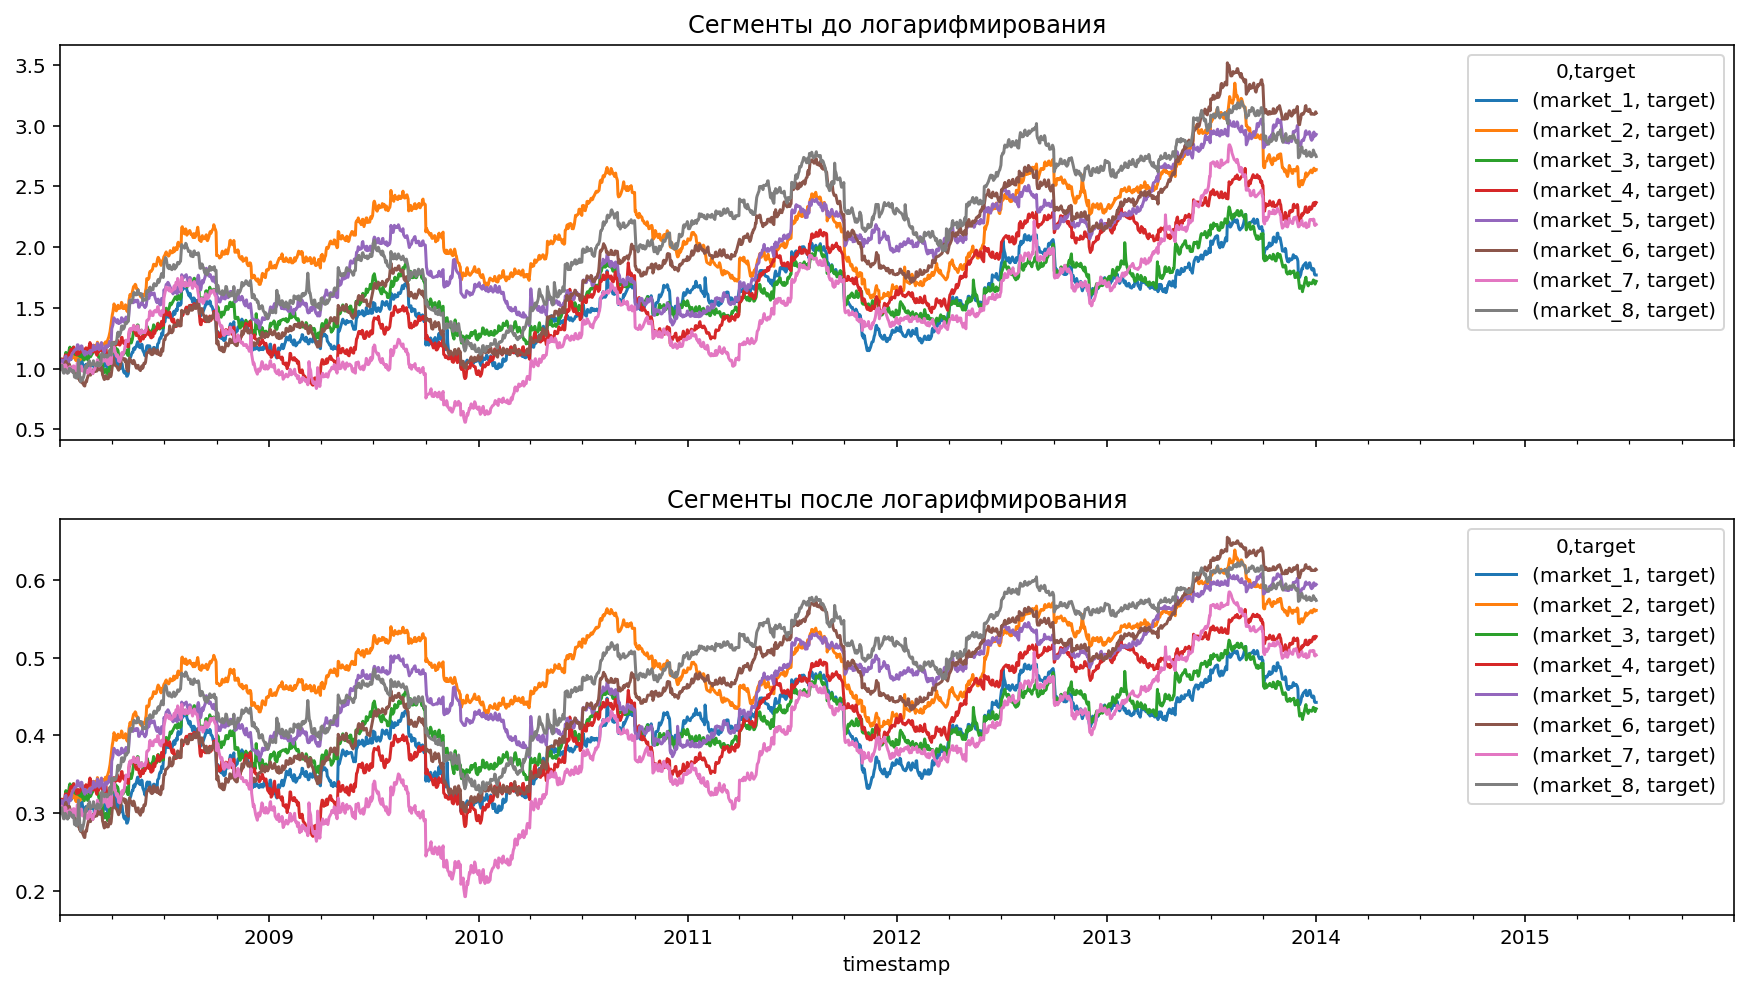

In [139]:
# визуализируем сегменты до и после логарифмирования
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
data.loc['2008-01-02': '2014-01-01'].plot(
    ax=axes[0], 
    title='Сегменты до логарифмирования')
train.plot(
    ax=axes[1], 
    title='Сегменты после логарифмирования');

### 3. Удаление тренда из прологарифмированной зависимой переменной

In [140]:
# создаем экземпляр класса LinearRegression 
# для вычисления тренда
regressor = LinearRegression()

# для каждого сегмента будем обучать модель, прогнозирующую 
# тренд, поэтому создадим словарь, в котором для каждого 
# сегмента будет храниться своя модель
trend_models = {}

# для каждого сегмента делаем копию линейной модели
for segment in segments:
    trend_models[segment] = deepcopy(regressor)

In [141]:
# в переменную results будем сохранять сегменты 
# с прологарифмированной зависимой переменной,
# из которой удален тренд
results = []

# для каждого сегмента
for segment in segments:

    # формируем набор
    seg_df = train[segment][:max_date_in_dataset]
    seg_df = seg_df[seg_df.first_valid_index():]

    # формируем массив признаков из временных меток
    series_len = len(seg_df)
    x = seg_df.index.to_series()
    x = x.apply(lambda ts: ts.timestamp())
    x = x.to_numpy().reshape(series_len, 1)

    # формируем массив меток
    y = seg_df['target'].tolist()

    # из словаря берем модель (еще необученную) для текущего сегмента 
    regressor = trend_models[segment]

    # обучаем линейную модель 
    regressor.fit(x, y)

    # прогнозируем тренд
    trend = regressor.predict(x)

    # удаляем тренд из зависимой переменной
    no_trend_y = y - trend

    # делаем копию сегмента
    seg_df_notrend = seg_df.copy()

    # заменяем зависимую переменную на зависимую переменную без тренда
    seg_df_notrend['target'] = no_trend_y

    # вернем даты прогноза
    seg_df_notrend = seg_df_notrend.reindex(new_index)

    # приведем столбцы датафрейма к формату Multiindex
    idx = seg_df_notrend.columns.to_frame()
    idx.insert(0, 'segment', segment)
    seg_df_notrend.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем набор с удаленным трендом 
    results.append(seg_df_notrend)

# собираем все сегменты с удаленным трендом вместе в один датафрейм
train_notrends = pd.concat(results, axis=1)
train_notrends = train_notrends.sort_index(axis=1)
# смотрим первые 5 наблюдений получившегося датафрейма
train_notrends.head()

segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2008-01-02,-0.02747,-0.12021,-0.05536,-0.00218,-0.06227,-0.00059,0.02483,-0.05970
2008-01-03,-0.02589,-0.11876,-0.05485,-0.00077,-0.05916,0.00204,0.02669,-0.05911
2008-01-04,-0.02431,-0.11472,-0.04611,0.00718,-0.05155,0.00464,0.03268,-0.05472
2008-01-05,-0.02647,-0.11072,-0.04530,0.01460,-0.04726,0.00207,0.03153,-0.05398
2008-01-06,-0.02865,-0.12024,-0.04449,0.00950,-0.05239,-0.00051,0.03039,-0.06224


In [142]:
# смотрим на новый датафрейм: в наблюдениях, приходящихся
# на горизонт прогнозирования, зависимая переменная имеет
# пропуски
train_notrends.tail(HORIZON + 1)

segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2014-01-01,-0.02635,0.00149,-0.03148,0.00488,0.02751,0.00909,0.01766,-0.03772
2014-01-02,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-03,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-04,nan,nan,nan,nan,nan,nan,nan,nan
2014-01-05,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...
2015-12-27,nan,nan,nan,nan,nan,nan,nan,nan
2015-12-28,nan,nan,nan,nan,nan,nan,nan,nan


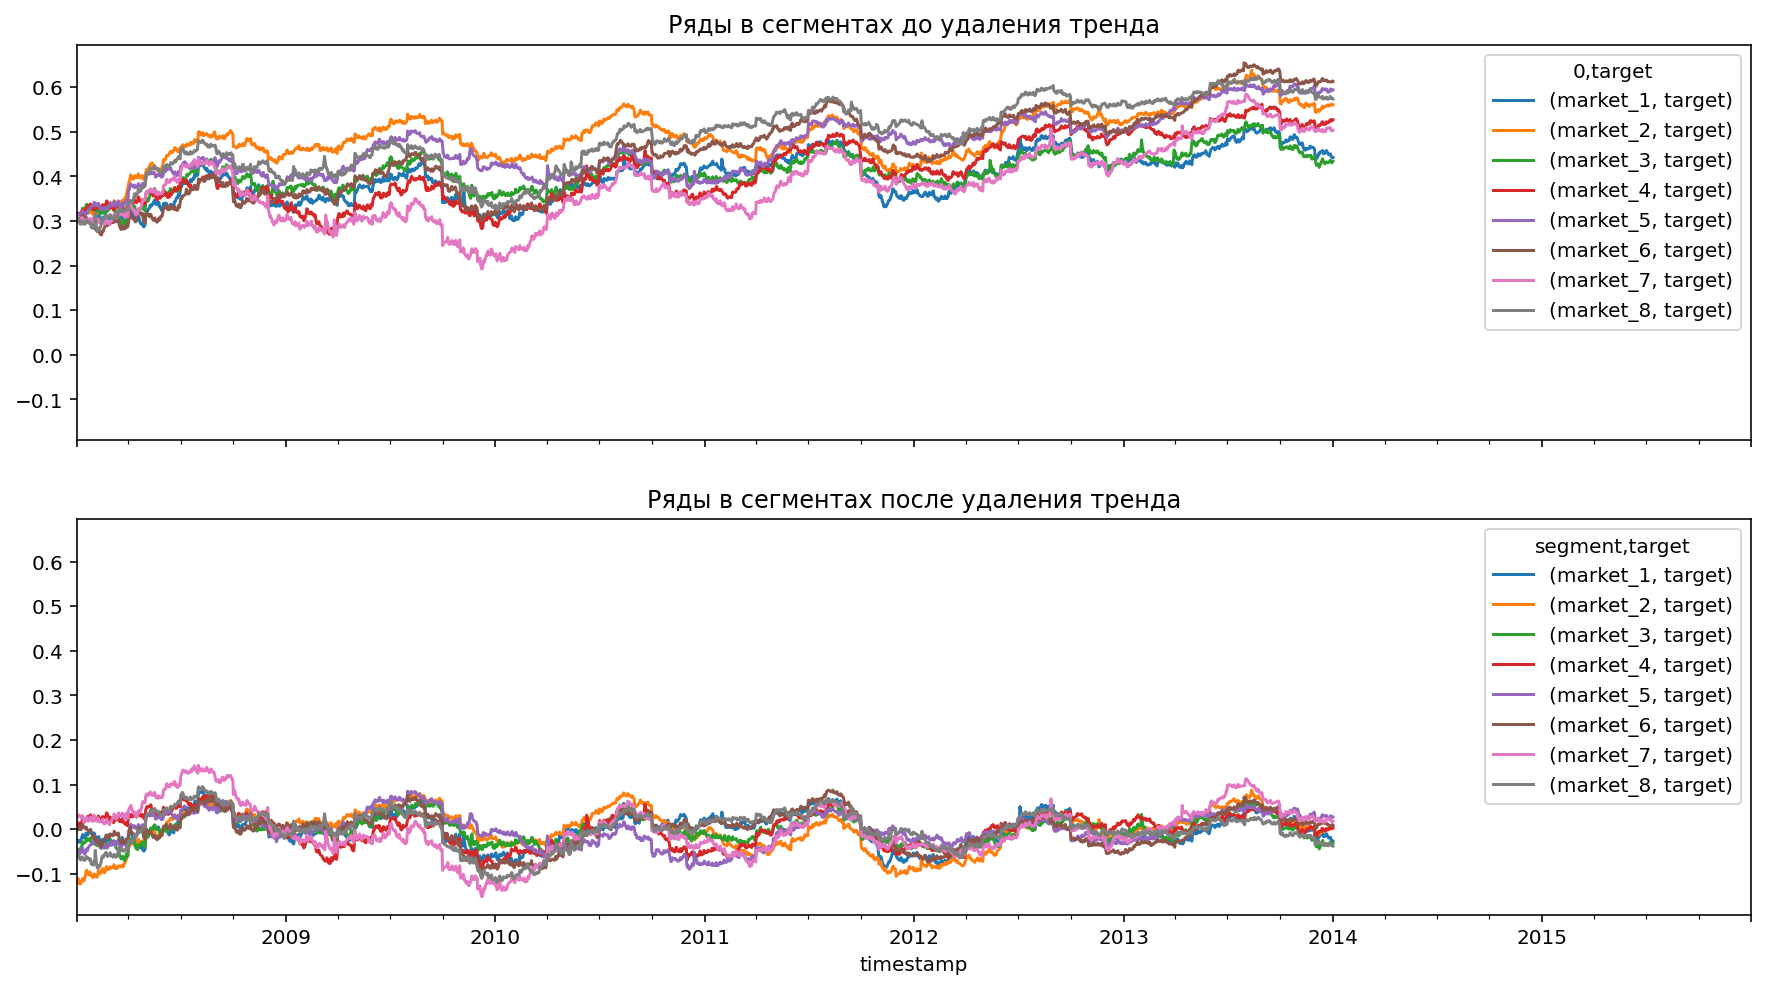

In [143]:
# визуализируем уже прологарифмированные ряды 
# в сегментах до и после удаления тренда
fig, axes = plt.subplots(2, 1, figsize=(15, 8), 
                         sharex=True, sharey=True)
ttl_train = 'Ряды в сегментах до удаления тренда'
train.plot(ax=axes[0], 
           title=ttl_train)
ttl_train_notrends = 'Ряды в сегментах после удаления тренда'
train_notrends.plot(ax=axes[1], 
                    title=ttl_train_notrends);

### 4. Создание лагов

In [144]:
# в переменную results будем сохранять
# сегменты с лагами
results = []

# задаем список, каждый элемент - количество периодов для лага
lags = list(range(750, 1501, 250))

# для каждого сегмента
for segment in segments:
    # формируем набор
    seg_df = train_notrends[segment].copy()

    # для каждого элемента списка
    for lag in lags:
        # создаем лаг
        seg_df[f'lag_{lag}'] = seg_df['target'].shift(lag)

    # приведем столбцы датафрейма к формату Multiindex
    idx = seg_df.columns.to_frame()
    idx.insert(0, 'segment', segment)
    seg_df.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем набор с созданными лагами
    results.append(seg_df)

# собираем все сегменты с лагами вместе в один датафрейм
train_notrends_lags = pd.concat(results, axis=1)
train_notrends_lags = train_notrends_lags.sort_index(axis=1)

# смотрим на новый датафрейм: в наблюдениях, приходящихся
# на горизонт прогнозирования, зависимая переменная имеет
# пропуски
train_notrends_lags.tail(HORIZON + 1)

segment    market_1                                     market_2           \
target     lag_1000 lag_1250 lag_1500  lag_750   target lag_1000 lag_1250   
timestamp                                                                   
2014-01-01  0.01614  0.00881 -0.04727 -0.07339 -0.02635 -0.03565  0.06402   
2014-01-02  0.02139  0.02242 -0.04882 -0.07425      nan -0.03146  0.06848   
2014-01-03  0.02345  0.02255 -0.04841 -0.07376      nan -0.03195  0.06974   
2014-01-04  0.01710  0.02268 -0.04776 -0.06918      nan -0.03737  0.06821   
2014-01-05  0.01826  0.02251 -0.04251 -0.06880      nan -0.03745  0.06728   
...             ...      ...      ...      ...      ...      ...      ...   
2015-12-27 -0.02591  0.02385 -0.07329 -0.01626      nan  0.00930  0.00819   
2015-12-28 -0.02107  0.02298 -0.07300 -0.01721      nan  0.00945  0.00933   
2015-12-29 -0.02539  0.02888 -0.07271 -0.01338      nan  0.00960  0.01365   
2015-12-30 -0.02676  0.02910 -0.06840 -0.01249      nan  0.01204  0.01248   
2015-12-31 -0.02120  0.02604 -0.06413 -0.01175      nan  0.01446  0.01131   

segment                              market_3                             \
target     lag_1500  lag_750  target lag_1000 lag_1250 lag_1500  lag_750   
timestamp                                                                  
2014-01-01  0.00157 -0.09625 0.00149 -0.00277  0.02939 -0.02841 -0.03654   
2014-01-02 -0.00209 -0.09597     nan  0.00177  0.04143 -0.03326 -0.03561   
2014-01-03 -0.00578 -0.09661     nan  0.00460  0.04305 -0.03486 -0.03468   
2014-01-04 -0.00671 -0.09277     nan -0.00338  0.04378 -0.03095 -0.03018   
2014-01-05 -0.00735 -0.09333     nan -0.00266  0.04726 -0.02706 -0.02999   
...             ...      ...     ...      ...      ...      ...      ...   
2015-12-27 -0.09615 -0.00789     nan  0.00154 -0.00180 -0.02241 -0.03771   
2015-12-28 -0.09458 -0.01219     nan -0.00476 -0.00334 -0.01904 -0.04406   
2015-12-29 -0.09769 -0.01036     nan -0.01015  0.00160 -0.02232 -0.04017   
2015-12-30 -0.09621 -0.00888     nan -0.01318  0.00300 -0.02288 -0.03800   
2015-12-31 -0.09474 -0.00740     nan -0.01083 -0.00210 -0.02273 -0.03445   

segment             market_4                                    market_5  \
target       target lag_1000 lag_1250 lag_1500  lag_750  target lag_1000   
timestamp                                                                  
2014-01-01 -0.03148 -0.00984  0.02598 -0.05487 -0.04612 0.00488 -0.04536   
2014-01-02      nan -0.00525  0.03777 -0.05794 -0.04659     nan -0.04141   
2014-01-03      nan -0.00070  0.03767 -0.06104 -0.04695     nan -0.04159   
2014-01-04      nan -0.00488  0.03647 -0.05947 -0.04374     nan -0.04613   
2014-01-05      nan -0.00343  0.03901 -0.04917 -0.04316     nan -0.05071   
...             ...      ...      ...      ...      ...     ...      ...   
2015-12-27      nan  0.00236  0.01226 -0.04599 -0.00467     nan  0.02052   
2015-12-28      nan  0.00167  0.01522 -0.04437 -0.00664     nan  0.02276   
2015-12-29      nan  0.00148  0.02190 -0.04815 -0.00487     nan  0.02231   
2015-12-30      nan -0.00002  0.02376 -0.04672 -0.00481     nan  0.02201   
2015-12-31      nan  0.00409  0.02020 -0.04767 -0.00318     nan  0.02169   

segment                                       market_6                    \
target     lag_1250 lag_1500  lag_750  target lag_1000 lag_1250 lag_1500   
timestamp                                                                  
2014-01-01 -0.00607  0.02111 -0.01006 0.02751  0.01797  0.03087 -0.06833   
2014-01-02  0.00539  0.01958 -0.01126     nan  0.02296  0.03998 -0.07112   
2014-01-03  0.00550  0.01858 -0.00993     nan  0.02231  0.04179 -0.07018   
2014-01-04  0.00357  0.01719 -0.00735     nan  0.02166  0.04039 -0.06924   
2014-01-05  0.00409  0.01679 -0.01116     nan  0.02351  0.04162 -0.06235   
...             ...      ...      ...     ...      ...      ...      ...   
2015-12-27  0.01077  0.00044  0.02428     nan -0.02835  0.01397 -0.04020   
2015-12-28  0.00997  0.00222  0

###  5. Создание календарных признаков

In [145]:
# напишем функцию для создания календарных признаков
def create_calendar_vars(df):
    df['year'] = df.index.year.astype('category') 
    df['month'] = df.index.month.astype('category') 
    df['dayofmonth'] = df.index.day.astype('category') 
    df['dayofweek'] = df.index.dayofweek.astype('category') 
    df['weekofyear'] = df.index.weekofyear.astype('category')
    df['is_weekend'] = pd.Series(df.index).apply(
        lambda x : x.weekday() in [5, 6]).values 
    df['is_weekend'] = df['is_weekend'].astype('category')
    return df

In [146]:
# в переменную results будем сохранять 
# сегменты с календарными признаками
results = []

# для каждого сегмента
for segment in segments:
    
    # формируем набор
    cal_seg_df = train_notrends_lags[segment].copy()

    # создаем календарные признаки, используя 
    # функцию create_calendar_vars()
    cal_seg_df = create_calendar_vars(cal_seg_df)

    # приводим столбцы датафрейма к формату Multiindex
    idx = cal_seg_df.columns.to_frame()
    idx.insert(0, 'segment', segment)
    cal_seg_df.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем набор с календарными признаками
    results.append(cal_seg_df)

# собираем все сегменты с календарными 
# признаками вместе в один датафрейм
train_notrends_lags_cal = pd.concat(results, axis=1)
train_notrends_lags_cal = train_notrends_lags_cal.sort_index(axis=1)
# смотрим первые 5 наблюдений получившегося датафрейма
train_notrends_lags_cal.head()

segment      market_1                                                          \
target     dayofmonth dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750   
timestamp                                                                       
2008-01-02          2         2      False      nan      nan      nan     nan   
2008-01-03          3         3      False      nan      nan      nan     nan   
2008-01-04          4         4      False      nan      nan      nan     nan   
2008-01-05          5         5       True      nan      nan      nan     nan   
2008-01-06          6         6       True      nan      nan      nan     nan   

segment                                      market_2                       \
target     month   target weekofyear  year dayofmonth dayofweek is_weekend   
timestamp                                                                    
2008-01-02     1 -0.02747          1  2008          2         2      False   
2008-01-03     1 -0.02589          1  2008          3         3      False   
2008-01-04     1 -0.02431          1  2008          4         4      False   
2008-01-05     1 -0.02647          1  2008          5         5       True   
2008-01-06     1 -0.02865          1  2008          6         6       True   

segment                                                                        \
target     lag_1000 lag_1250 lag_1500 lag_750 month   target weekofyear  year   
timestamp                                                                       
2008-01-02      nan      nan      nan     nan     1 -0.12021          1  2008   
2008-01-03      nan      nan      nan     nan     1 -0.11876          1  2008   
2008-01-04      nan      nan      nan     nan     1 -0.11472          1  2008   
2008-01-05      nan      nan      nan     nan     1 -0.11072          1  2008   
2008-01-06      nan      nan      nan     nan     1 -0.12024          1  2008   

segment      market_3                                                          \
target     dayofmonth dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750   
timestamp                                                                       
2008-01-02          2         2      False      nan      nan      nan     nan   
2008-01-03          3         3      False      nan      nan      nan     nan   
2008-01-04          4         4      False      nan      nan      nan     nan   
2008-01-05          5         5       True      nan      nan      nan     nan   
2008-01-06          6         6       True      nan      nan      nan     nan   

segment                                      market_4                       \
target     month   target weekofyear  year dayofmonth dayofweek is_weekend   
timestamp                                                                    
2008-01-02     1 -0.05536          1  2008          2         2      False   
2008-01-03     1 -0.05485          1  2008          3         3      False   
2008-01-04     1 -0.04611          1  2008          4         4      False   
2008-01-05     1 -0.04530          1  2008          5         5       True   
2008-01-06     1 -0.04449          1  2008          6         6       True   

segment                                                                        \
target     lag_1000 lag_1250 lag_1500 lag_750 month   target weekofyear  year   
timestamp                                                                       
2008-01-02      nan      nan      nan     nan     1 -0.00218          1  2008   
2008-01-03      nan      nan      nan     nan     1 -0.00077          1  2008   
2008-01-04      nan      nan      nan     nan     1  0.00718          1  2008   
2008-01-05      nan      nan      nan     nan     1  0.01460          1  2008   
2008-01-06      nan      nan      nan     nan     1  0.00950          1  2008   

segment      market_5                                                          \
target     dayofmonth dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag

### 6. Кодирование сегментов скользящими средними

In [147]:
# функция для создания скользящих статистик
def moving_stats(series, alpha=1, seasonality=1, periods=1, min_periods=1, 
                 window=4, aggfunc='mean', fillna=None): 
    """
    Создает скользящие статистики.
    
    Параметры
    ----------
    alpha: int, по умолчанию 1
        Коэффициент регрессии.
    seasonality: int, по умолчанию 1
        Коэффициент сезонности.
    periods: int, по умолчанию 1
        Порядок лага, с которым вычисляем скользящие 
        статистики.    
    min_periods: int, по умолчанию 1
        Минимальное количество наблюдений в окне для
        вычисления скользящих статистик.
    window: int, по умолчанию 4
        Ширина окна. Не должна быть меньше
        горизонта прогнозирования.
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция.  
    fillna, int, по умолчанию 0
        Стратегия импутации пропусков.
    """
    # задаем размер окна для определения диапазона коэффициентов 
    size = window if window != -1 else len(series) - 1
    # задаем диапазон значений коэффициентов в виде списка
    alpha_range = [alpha ** i for i in range(0, size)]
    # задаем минимально требуемое количество наблюдений в окне для
    # вычисления скользящего среднего с поправкой на сезонность 
    min_required_len = max(min_periods - 1, 0) * seasonality + 1
    
    # функция для получения лагов в соответствии с заданной сезонностью 
    def get_required_lags(series):
        # возвращает вычисленные лаги в соответствии с заданной сезонностью 
        return pd.Series(series.values[::-1][:: seasonality])
        
    # функция для вычисления скользящей статистики
    def aggregate_window(series):
        tmp_series = get_required_lags(series)
        size = len(tmp_series)
        tmp = tmp_series * alpha_range[-size:]

        if aggfunc == 'mdad':
            return tmp.to_frame().agg(
                lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))))
        else:
            return tmp.agg(aggfunc)
    
    # собственно вычисление скользящих статистик
    features = series.shift(periods=periods).rolling(
        window=seasonality * window if window != -1 else len(series) - 1, 
        min_periods=min_required_len).aggregate(aggregate_window)
    
    # импутируем пропуски
    if fillna is not None:
        features.fillna(fillna, inplace=True)
        
    return features

In [148]:
# в переменную results будем сохранять сегменты 
# со скользящим средним с шириной окна, равной
# длине набора до удлинения минус 1
results = []

# для каждого сегмента
for segment in segments:
    
    # формируем набор
    enc_seg_df = train_notrends_lags_cal[segment].copy()

    # кодируем сегмент, используя функцию moving_stats()
    enc_seg_df['regressor_segment_mean'] = moving_stats(
        enc_seg_df['target'], 
        alpha=1, 
        seasonality=1, 
        min_periods=1, 
        window=-1, 
        aggfunc='mean')
    
    # вычисляем глобальное среднее
    global_means = enc_seg_df['target'].mean()

    # заменяем пропуски глобальным средним
    enc_seg_df['regressor_segment_mean'].fillna(
        global_means, inplace=True)
    
    # приведем столбцы датафрейма к формату Multiindex
    idx = enc_seg_df.columns.to_frame()
    idx.insert(0, 'segment', segment)
    enc_seg_df.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем набор
    results.append(enc_seg_df)

# собираем все сегменты вместе в один датафрейм
train_notrends_lags_cal_enc = pd.concat(results, axis=1)
train_notrends_lags_cal_enc = train_notrends_lags_cal_enc.sort_index(axis=1)
# смотрим первые 5 наблюдений получившегося датафрейма
train_notrends_lags_cal_enc.head()

segment      market_1                                                          \
target     dayofmonth dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750   
timestamp                                                                       
2008-01-02          2         2      False      nan      nan      nan     nan   
2008-01-03          3         3      False      nan      nan      nan     nan   
2008-01-04          4         4      False      nan      nan      nan     nan   
2008-01-05          5         5       True      nan      nan      nan     nan   
2008-01-06          6         6       True      nan      nan      nan     nan   

segment                                                             market_2  \
target     month regressor_segment_mean   target weekofyear  year dayofmonth   
timestamp                                                                      
2008-01-02     1               -0.00000 -0.02747          1  2008          2   
2008-01-03     1               -0.02747 -0.02589          1  2008          3   
2008-01-04     1               -0.02668 -0.02431          1  2008          4   
2008-01-05     1               -0.02589 -0.02647          1  2008          5   
2008-01-06     1               -0.02604 -0.02865          1  2008          6   

segment                                                                   \
target     dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750 month   
timestamp                                                                  
2008-01-02         2      False      nan      nan      nan     nan     1   
2008-01-03         3      False      nan      nan      nan     nan     1   
2008-01-04         4      False      nan      nan      nan     nan     1   
2008-01-05         5       True      nan      nan      nan     nan     1   
2008-01-06         6       True      nan      nan      nan     nan     1   

segment                                                       market_3  \
target     regressor_segment_mean   target weekofyear  year dayofmonth   
timestamp                                                                
2008-01-02               -0.00000 -0.12021          1  2008          2   
2008-01-03               -0.12021 -0.11876          1  2008          3   
2008-01-04               -0.11948 -0.11472          1  2008          4   
2008-01-05               -0.11790 -0.11072          1  2008          5   
2008-01-06               -0.11610 -0.12024          1  2008          6   

segment                                                                   \
target     dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750 month   
timestamp                                                                  
2008-01-02         2      False      nan      nan      nan     nan     1   
2008-01-03         3      False      nan      nan      nan     nan     1   
2008-01-04         4      False      nan      nan      nan     nan     1   
2008-01-05         5       True      nan      nan      nan     nan     1   
2008-01-06         6       True      nan      nan      nan     nan     1   

segment                                                       market_4  \
target     regressor_segment_mean   target weekofyear  year dayofmonth   
timestamp                                                                
2008-01-02               -0.00000 -0.05536          1  2008          2   
2008-01-03               -0.05536 -0.05485          1  2008          3   
2008-01-04               -0.05511 -0.04611          1  2008          4   
2008-01-05               -0.05211 -0.04530          1  2008          5   
2008-01-06               -0.05041 -0.04449          1  2008          6   

segment                                                                   \
target     dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750 month   
timestamp                                                                  
2008-01-02         2      False      nan      nan      nan     nan     1   
20

### 7. Кодирование сегментов целочисленными значениями (Label Encoding) - ДОБАВИЛИ НОВУЮ ПРОЦЕДУРУ!

In [149]:
# создаем экземпляр класса LabelEncoder
le = LabelEncoder()
# получаем названия сегментов
segment_columns = train_notrends_lags_cal_enc.columns.get_level_values('segment')

In [150]:
# обучаем LabelEncoder
le.fit(segment_columns)
# получаем массив целочисленных кодов, например,
# market_1 получит код 0, а market_8 - код 7
encoded_matrix = le.transform(le.classes_)
# создаем массив целочисленных кодов размерностью
# длина набора x количество кодов 
encoded_matrix = encoded_matrix.reshape(
    len(le.classes_), -1).repeat(len(train_notrends_lags_cal_enc), axis=1).T
# получаем мультииндексный датафрейм, каждый сегмент
# которого содержит по одной переменной 
# regressor_segment_code
encoded_df = pd.DataFrame(
    encoded_matrix,
    columns=pd.MultiIndex.from_product(
        [le.classes_, ['regressor_segment_code']], 
        names=('segment', 'feature')),
    index=train_notrends_lags_cal_enc.index)
# все переменные в этом датафрейме превращаем
# в категориальные типа category
encoded_df = encoded_df.astype('category')
# присоединяем датафрейм к исходному
train_notrends_lags_cal_enc_label = train_notrends_lags_cal_enc.join(encoded_df)
# сортируем признаки
train_notrends_lags_cal_enc_label = train_notrends_lags_cal_enc_label.sort_index(axis=1)
train_notrends_lags_cal_enc_label.head()

segment      market_1                                                          \
target     dayofmonth dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750   
timestamp                                                                       
2008-01-02          2         2      False      nan      nan      nan     nan   
2008-01-03          3         3      False      nan      nan      nan     nan   
2008-01-04          4         4      False      nan      nan      nan     nan   
2008-01-05          5         5       True      nan      nan      nan     nan   
2008-01-06          6         6       True      nan      nan      nan     nan   

segment                                                                  \
target     month regressor_segment_code regressor_segment_mean   target   
timestamp                                                                 
2008-01-02     1                      0               -0.00000 -0.02747   
2008-01-03     1                      0               -0.02747 -0.02589   
2008-01-04     1                      0               -0.02668 -0.02431   
2008-01-05     1                      0               -0.02589 -0.02647   
2008-01-06     1                      0               -0.02604 -0.02865   

segment                       market_2                                         \
target     weekofyear  year dayofmonth dayofweek is_weekend lag_1000 lag_1250   
timestamp                                                                       
2008-01-02          1  2008          2         2      False      nan      nan   
2008-01-03          1  2008          3         3      False      nan      nan   
2008-01-04          1  2008          4         4      False      nan      nan   
2008-01-05          1  2008          5         5       True      nan      nan   
2008-01-06          1  2008          6         6       True      nan      nan   

segment                                                   \
target     lag_1500 lag_750 month regressor_segment_code   
timestamp                                                  
2008-01-02      nan     nan     1                      1   
2008-01-03      nan     nan     1                      1   
2008-01-04      nan     nan     1                      1   
2008-01-05      nan     nan     1                      1   
2008-01-06      nan     nan     1                      1   

segment                                                       market_3  \
target     regressor_segment_mean   target weekofyear  year dayofmonth   
timestamp                                                                
2008-01-02               -0.00000 -0.12021          1  2008          2   
2008-01-03               -0.12021 -0.11876          1  2008          3   
2008-01-04               -0.11948 -0.11472          1  2008          4   
2008-01-05               -0.11790 -0.11072          1  2008          5   
2008-01-06               -0.11610 -0.12024          1  2008          6   

segment                                                                   \
target     dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750 month   
timestamp                                                                  
2008-01-02         2      False      nan      nan      nan     nan     1   
2008-01-03         3      False      nan      nan      nan     nan     1   
2008-01-04         4      False      nan      nan      nan     nan     1   
2008-01-05         5       True      nan      nan      nan     nan     1   
2008-01-06         6       True      nan      nan      nan     nan     1   

segment                                                                       \
target     regressor_segment_code regressor_segment_mean   target weekofyear   
timestamp                                                                      
2008-01-02                      2               -0.00000 -0.05536          1   
2008-01-03                      2               -0.05536 -0.05485          1   
2008-01-04        

### 8. Вычисление скользящих средних

In [151]:
# добавим скользящие средние

# в переменную results будем сохранять 
# сегменты со скользящими средними
results = []

# для каждого сегмента
for segment in segments:
    
    # формируем удлиненный набор
    mov_mean_seg_df = train_notrends_lags_cal_enc_label[segment].copy()

    # получаем скользящее среднее, используя функцию moving_stats()
    mov_mean_seg_df['moving_mean_730'] = moving_stats(
        mov_mean_seg_df['target'], alpha=1, seasonality=1, 
        min_periods=1, window=730, aggfunc='mean')

    # заполним пропуски 0
    mov_mean_seg_df['moving_mean_730'].fillna(0, inplace=True)
    
    # приведем столбцы датафрейма к формату Multiindex
    idx = mov_mean_seg_df.columns.to_frame()
    idx.insert(0, 'segment', segment)
    mov_mean_seg_df.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем набор 
    results.append(mov_mean_seg_df)

# собираем все сегменты вместе в один датафрейм
train_notrends_lags_cal_enc_label_mean = pd.concat(results, axis=1)
train_notrends_lags_cal_enc_label_mean = train_notrends_lags_cal_enc_label_mean.sort_index(axis=1)
# смотрим первые 5 наблюдений получившегося датафрейма
train_notrends_lags_cal_enc_label_mean.head()

segment      market_1                                                          \
target     dayofmonth dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750   
timestamp                                                                       
2008-01-02          2         2      False      nan      nan      nan     nan   
2008-01-03          3         3      False      nan      nan      nan     nan   
2008-01-04          4         4      False      nan      nan      nan     nan   
2008-01-05          5         5       True      nan      nan      nan     nan   
2008-01-06          6         6       True      nan      nan      nan     nan   

segment                                                  \
target     month moving_mean_730 regressor_segment_code   
timestamp                                                 
2008-01-02     1         0.00000                      0   
2008-01-03     1        -0.02747                      0   
2008-01-04     1        -0.02668                      0   
2008-01-05     1        -0.02589                      0   
2008-01-06     1        -0.02604                      0   

segment                                                       market_2  \
target     regressor_segment_mean   target weekofyear  year dayofmonth   
timestamp                                                                
2008-01-02               -0.00000 -0.02747          1  2008          2   
2008-01-03               -0.02747 -0.02589          1  2008          3   
2008-01-04               -0.02668 -0.02431          1  2008          4   
2008-01-05               -0.02589 -0.02647          1  2008          5   
2008-01-06               -0.02604 -0.02865          1  2008          6   

segment                                                                   \
target     dayofweek is_weekend lag_1000 lag_1250 lag_1500 lag_750 month   
timestamp                                                                  
2008-01-02         2      False      nan      nan      nan     nan     1   
2008-01-03         3      False      nan      nan      nan     nan     1   
2008-01-04         4      False      nan      nan      nan     nan     1   
2008-01-05         5       True      nan      nan      nan     nan     1   
2008-01-06         6       True      nan      nan      nan     nan     1   

segment                                                                   \
target     moving_mean_730 regressor_segment_code regressor_segment_mean   
timestamp                                                                  
2008-01-02         0.00000                      1               -0.00000   
2008-01-03        -0.12021                      1               -0.12021   
2008-01-04        -0.11948                      1               -0.11948   
2008-01-05        -0.11790                      1               -0.11790   
2008-01-06        -0.11610                      1               -0.11610   

segment                                market_3                                \
target       target weekofyear  year dayofmonth dayofweek is_weekend lag_1000   
timestamp                                                                       
2008-01-02 -0.12021          1  2008          2         2      False      nan   
2008-01-03 -0.11876          1  2008          3         3      False      nan   
2008-01-04 -0.11472          1  2008          4         4      False      nan   
2008-01-05 -0.11072          1  2008          5         5       True      nan   
2008-01-06 -0.12024          1  2008          6         6       True      nan   

segment                                                     \
target     lag_1250 lag_1500 lag_750 month moving_mean_730   
timestamp                                                    
2008-01-02      nan      nan     nan     1         0.00000   
2008-01-03      nan      nan     nan     1        -0.05536   
2008-01-04      nan      nan     nan     1        -0.05511   
2008-01-05      nan      nan     nan     1    

### 9. Подготовка датафрейма к обучению

In [152]:
# выделяем из удлиненного датафрейма 
# обучающий датафрейм
train_df = train_notrends_lags_cal_enc_label_mean.head(-HORIZON)

# выделяем из удлиненного датафрейма 
# датафрейм с прогнозами
future_df = train_notrends_lags_cal_enc_label_mean.tail(HORIZON)

In [153]:
# создаем список для хранения данных сегментов
# и список категориальных признаков типа category
aggregator_list = []
category = []

# для каждого сегмента
for segment in segments:
    # если есть категориальные переменные
    if train_df[segment].select_dtypes(
        include=['category']).columns.to_list():
        # сохраним их в отдельный список категориальных 
        # признаков типа category
        category.extend(train_df[segment].select_dtypes(
            include=['category']).columns.to_list())
    # добавим данные сегмента в aggregator_list
    aggregator_list.append(train_df[segment].copy())
    # сохраним название сегмента в отдельном столбце
    aggregator_list[-1]['segment'] = segment

In [154]:
# собираем все сегменты вместе в один датафрейм
new_train_df = pd.concat(aggregator_list)
new_train_df = new_train_df.reset_index()

# для категориальных признаков установим тип данных category
category = list(set(category))
new_train_df[category] = new_train_df[category].astype('category')
new_train_df.columns.name = None

In [155]:
# удаляем наблюдения с пропусками, которые образовались 
# в процессе создания лагов
new_train_df = new_train_df.dropna()

# удаляем столбец, указывающий на сегмент,
# к которому относится наблюдение
new_train_df = new_train_df.drop(columns='segment')

# посмотрим на первые 5 наблюдений получившегося датафрейма
new_train_df.head()

,timestamp,dayofmonth,dayofweek,is_weekend,lag_1000,lag_1250,lag_1500,lag_750,month,moving_mean_730,regressor_segment_code,regressor_segment_mean,target,weekofyear,year
1500,2012-02-10,10,4,False,0.01904,0.04942,-0.02747,-0.05762,2,0.00083,0,0.00014,-0.07244,6,2012
1501,2012-02-11,11,5,True,0.01587,0.05132,-0.02589,-0.05320,2,0.00083,0,0.00009,-0.07448,6,2012
1502,2012-02-12,12,6,True,0.01588,0.05354,-0.02431,-0.05567,2,0.00082,0,0.00004,-0.07934,6,2012
1503,2012-02-13,13,0,False,0.01590,0.05532,-0.02647,-0.06063,2,0.00080,0,-0.00001,-0.08024,7,2012
1504,2012-02-14,14,1,False,0.01678,0.06278,-0.02865,-0.06564,2,0.00077,0,-0.00006,-0.07833,7,2012


### 10. Обучение модели в режиме MultiSegment

In [156]:
# cохраним в новые переменные обучающий и тестовый наборы,
# чтобы при обучении новой модели не создавать признаки
# заново
new_train_df_multi = new_train_df.copy()
future_df_multi = future_df.copy()

In [157]:
# создаем экземпляр класса CatBoostRegressor
# с гиперпараметрами по умолчанию
model = CatBoostRegressor()

# сохраним отдельно датафрейм с признаками модели, 
# но без зависимой переменной и даты
features = new_train_df_multi.drop(
    columns=['timestamp', 'target'])

# отдельно сохраняем столбец с зависимой переменной
target = new_train_df_multi['target']

# определяем категориальные признаки 
# (для модели Catboost)
cat_feat = features.select_dtypes(
    include=['category']).columns.to_list()

# задаем набор для обучения
train_pool = Pool(features, 
                  target.values, 
                  cat_features=cat_feat)

# обучаем модель Catboost
model.fit(train_pool, silent=True);

In [158]:
# создадим список, куда будем сохранять прогнозы для каждого сегмента 
result_list = list()

# для каждого сегмента из набора с прогнозами
for segment in segments:

    # формируем набор прогнозов для текущего сегмента
    segment_features = future_df_multi[segment]
    
    # сбросим индекс 
    segment_features = segment_features.reset_index()

    # сохраним даты в отдельный столбец
    dates = segment_features['timestamp']

    # удалим timestamp
    segment_features.drop('timestamp', axis=1, inplace=True)
    segment_features.drop('target', axis=1, inplace=True)
    
    # сбросим индекс для столбца с датами
    dates.reset_index(drop=True, inplace=True)

    # получим прогноз для сегмента, используя модель 
    # CatboostRegressor, обученной на всех сегментах
    segment_predict = model.predict(segment_features)

    # преобразуем прогнозы в датафрейм
    segment_predict = pd.DataFrame({'target': segment_predict})

    # добавим название сегмента для восстановения 
    # прогнозов для каждого сегмента
    segment_predict['segment'] = segment

    # добавим даты
    segment_predict['timestamp'] = dates
    
    # добавим датафрейм с прогнозами для текущего
    # сегмента в ранее созданный список
    result_list.append(segment_predict)

# cписок с прогнозами преобразуем в датафрейм
result_df = pd.concat(result_list, ignore_index=True)

# в качестве индекса установим дату и сегмент
result_df = result_df.set_index(['timestamp', 'segment'])

# напечатаем прогнозы для первых 5 наблюдений
result_df.head()

,,target
timestamp,segment,
2014-01-02,market_1,-0.02838
2014-01-03,market_1,-0.03014
2014-01-04,market_1,-0.03029
2014-01-05,market_1,-0.03205
2014-01-06,market_1,-0.03349


### 11. Выполнение обратных преобразований прогнозов для режима MultiSegment (добавление тренда и экспоненцирование)

In [159]:
# "развернем" датафрейм с прогнозами, чтобы сегменты 
# набора прогнозов расположились по столбцам
predict_df_multi = pd.pivot_table(
    result_df, values='target', index='timestamp', 
    columns='segment', aggfunc='sum', fill_value=0)

# приведем столбцы датафрейма к формату Multiindex
idx = predict_df_multi.columns.to_frame()
idx.insert(1, 'target', 'target')
predict_df_multi.columns = pd.MultiIndex.from_frame(idx)

# посмотрим на первые 5 прогнозов для каждого сегмента
predict_df_multi.head()

segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2014-01-02,-0.02838,-0.01050,-0.02903,0.00559,0.01978,-0.00774,0.01517,-0.03953
2014-01-03,-0.03014,-0.01440,-0.03030,0.00199,0.01724,-0.01055,0.01101,-0.03881
2014-01-04,-0.03029,-0.02112,-0.02989,0.00211,0.01682,-0.01127,0.01063,-0.03886
2014-01-05,-0.03205,-0.01391,-0.03058,0.00263,0.01932,-0.00722,0.01163,-0.03567
2014-01-06,-0.03349,-0.01603,-0.03184,0.00201,0.01302,-0.01076,0.00999,-0.03801


In [160]:
# добавляем тренд к прогнозам

# в переменную results будем сохранять датафрейм для 
# каждого сегмента после добавления тренда
results = []

# для каждого сегмента
for segment in segments:

    # формируем набор с прогнозами, к которым будем добавлять тренд
    pred_seg_df = predict_df_multi[segment]
    pred_seg_df = pred_seg_df[pred_seg_df.first_valid_index():]
    
    # формируем массив признаков из дат
    series_len = len(pred_seg_df)
    x = pred_seg_df.index.to_series()
    x = x.apply(lambda ts: ts.timestamp())
    x = x.to_numpy().reshape(series_len, 1)

    # формируем массив меток
    y = pred_seg_df['target'].tolist()

    # находим нужную модель линейной регрессии (уже обученную) 
    # для текущего сегмента 
    regressor = trend_models[segment]

    # предсказываем тренд для нужного сегмента
    trend = regressor.predict(x)

    # добавляем тренд к прогнозу
    trend_timeseries = y + trend 

    # делаем копию сегмента
    seg_df_trend = pred_seg_df.copy()

    # в качестве зависимой переменной сохраним 
    # прогноз с добавленным трендом
    seg_df_trend['target'] = trend_timeseries

    # приведем столбцы прогнозов к формату Multiindex
    idx = seg_df_trend.columns.to_frame()
    idx.insert(0, 'segment', segment)
    seg_df_trend.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем прогнозы с добавленным трендом для сегмента
    results.append(seg_df_trend)

# собираем все прогнозы сегментов с добавленным 
# трендом вместе в один датафрейм
final_predict_df_multi = pd.concat(results, axis=1)
final_predict_df_multi = final_predict_df_multi.sort_index(axis=1)
# посмотрим на первые 5 прогнозов с добавленным трендом
# для каждого сегмента
final_predict_df_multi.head()

segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2014-01-02,0.44050,0.54888,0.43668,0.52796,0.58642,0.59638,0.50088,0.57179
2014-01-03,0.43880,0.54505,0.43546,0.52445,0.58397,0.59372,0.49682,0.57263
2014-01-04,0.43872,0.53840,0.43592,0.52468,0.58364,0.59313,0.49653,0.57269
2014-01-05,0.43702,0.54567,0.43528,0.52529,0.58624,0.59732,0.49763,0.57599
2014-01-06,0.43565,0.54361,0.43407,0.52477,0.58002,0.59392,0.49608,0.57377


In [161]:
# избавляемся от логарифма (выполняем экспоненцирование)
for segment in segments:
    final_predict_df_multi[segment]['target'] = final_predict_df_multi[segment]['target'].apply(
        lambda x: math.pow(10, x) - 1)

In [162]:
# посмотрим в каждом сегменте на первые 5 прогнозов с добавленным
# трендом, к которым применили экспоненцирование
final_predict_df_multi.head()

segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2014-01-02,1.75741,2.53903,1.73324,2.37254,2.85852,2.94804,2.16871,2.73071
2014-01-03,1.74665,2.50794,1.72556,2.34543,2.83681,2.92389,2.13917,2.73790
2014-01-04,1.74610,2.45459,1.72845,2.34716,2.83391,2.91860,2.13712,2.73843
2014-01-05,1.73541,2.51292,1.72443,2.35191,2.85692,2.95655,2.14509,2.76697
2014-01-06,1.72676,2.49628,1.71686,2.34791,2.80211,2.92569,2.13387,2.74777


### 12. Оценка качества прогнозов для режима MultiSegment

In [125]:
# напишем функцию для вычисления метрики качества SMAPE
def smape_metric(y_true, y_pred, eps=1e-15):
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (
        np.abs(y_true) + np.abs(y_pred)).clip(eps))
    return smape

In [126]:
# вычисляем метрику качества для каждого сегмента
for segment in segments:
    smp = smape_metric(
        test[segment]['target'], 
        final_predict_df_multi[segment]['target'])
    print(segment, ': ', smp)

market_1 :  5.06724699762366
market_2 :  10.167487631787283
market_3 :  13.239269923646868
market_4 :  26.267887335939577
market_5 :  14.54947730441362
market_6 :  4.72874208233797
market_7 :  13.737416436640352
market_8 :  9.019542976603816


### 13. Визуализация прогнозов для режима MultiSegment

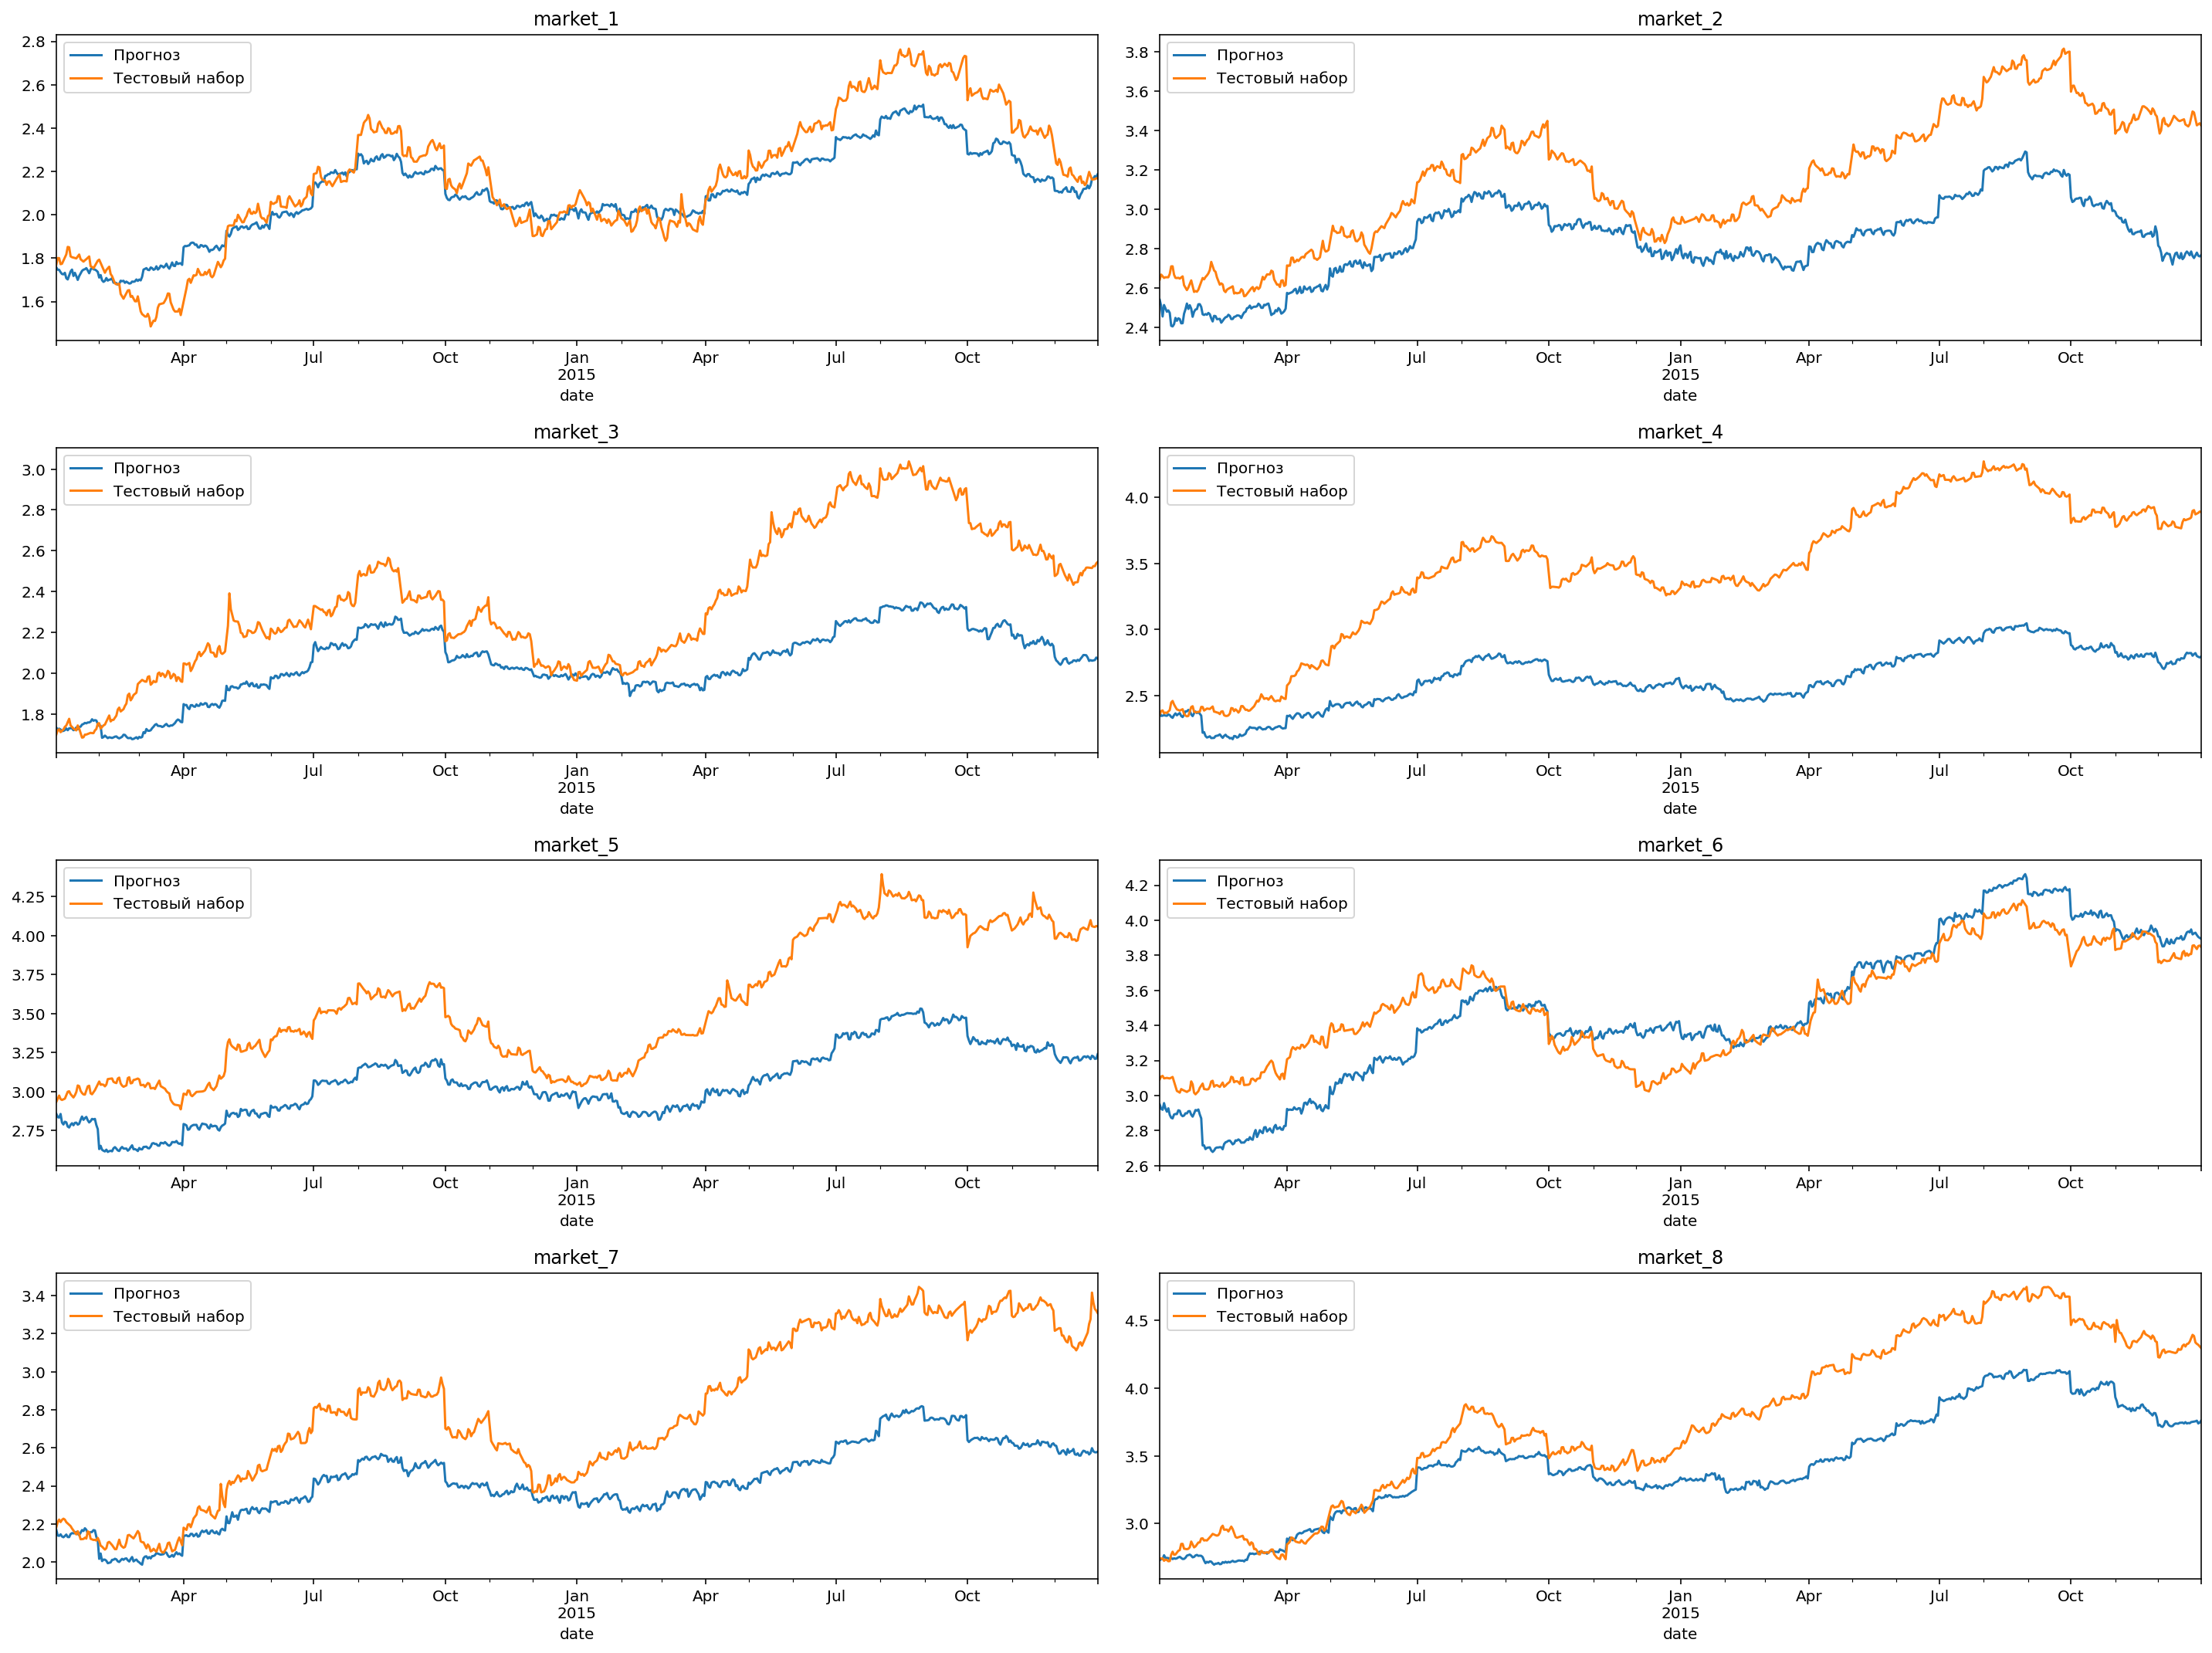

In [38]:
# настраиваем вид графика прогнозов
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
axes = axes.ravel()

# для каждого сегмента
for i, segment in enumerate(segments):
    # построим график прогнозов
    final_predict_df_multi[segment]['target'].plot(
        ax=axes[i], label='Прогноз', legend=True)
    # построим график фактических значений
    test[segment]['target'].plot(
        ax=axes[i], label='Тестовый набор', legend=True)
    axes[i].set_title(segment)
plt.tight_layout()

### 14. Проверка правильности восстановления прогнозов ETNA в режиме MultiSegment

In [57]:
# снова загружаем данные
data_etna = pd.read_csv('Data/advert/sales_train.csv', 
                        parse_dates=['date'])

In [58]:
# заполним пропуски с помощью линейной интерполяции 
for i in data_etna.columns:
    data_etna[i] = data_etna[i].interpolate(method='linear')

In [59]:
# подготовим данные для ETNA
data_etna = pd.melt(data_etna, 
                    id_vars=['date'],
                    value_vars=None, 
                    var_name='segment', 
                    value_name='target')

# переименовываем столбцы согласно требованияем ETNA 
# (должны быть 'timestamp', 'segment', 'target')
data_etna = data_etna.rename(
    columns={'date': 'timestamp'})
data_etna.head()

,timestamp,segment,target
0,2008-01-02,market_1,1.00000
1,2008-01-03,market_1,1.00759
2,2008-01-04,market_1,1.01519
3,2008-01-05,market_1,1.00547
4,2008-01-06,market_1,0.99576


In [60]:
# преобразовываем датафрейм в формат ETNA
df = TSDataset.to_dataset(data_etna)
ts = TSDataset(df, freq='D')

In [61]:
# готовим конвейер преобразований

# логарифмирование зависимой переменной
log = LogTransform(in_column='target')

# удаление тренда
trend = LinearTrendTransform(in_column='target')

# создание лагов
lags = LagTransform(in_column='target', 
                    lags=list(range(750, 1501, 250)), 
                    out_column='lag')

# создание календарных признаков
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             year_number=True,
                             out_column='date')

# кодирование сегментов скользящими средними
seg = MeanSegmentEncoderTransform()

# кодирование сегментов целочисленными значениями
label = SegmentEncoderTransform()

# создание скользящего среднего
mean730 = MeanTransform(in_column='target', 
                        window=730, 
                        min_periods=1, 
                        alpha=1, 
                        out_column='moving_mean')

In [62]:
# делим набор на обучающую и тестовую выборку
train_ts, test_ts = ts.train_test_split(
    train_start='2008-01-02',
    train_end='2014-01-01',
    test_start='2014-01-02',
    test_end='2015-12-31')

In [63]:
# выполняем преобразования обучающего набора
train_ts.fit_transform([log, trend, lags, d_flags, seg, label, mean730])
train_ts

segment                    market_1                                          \
feature    date_day_number_in_month date_day_number_in_week date_is_weekend   
timestamp                                                                     
2008-01-02                        2                       2           False   
2008-01-03                        3                       3           False   
2008-01-04                        4                       4           False   
2008-01-05                        5                       5            True   
2008-01-06                        6                       6            True   
...                             ...                     ...             ...   
2013-12-28                       28                       5            True   
2013-12-29                       29                       6            True   
2013-12-30                       30                       0           False   
2013-12-31                       31                       1           False   
2014-01-01                        1                       2           False   

segment                                                        \
feature    date_month_number_in_year date_week_number_in_year   
timestamp                                                       
2008-01-02                         1                        1   
2008-01-03                         1                        1   
2008-01-04                         1                        1   
2008-01-05                         1                        1   
2008-01-06                         1                        1   
...                              ...                      ...   
2013-12-28                        12                       52   
2013-12-29                        12                       52   
2013-12-30                        12                        1   
2013-12-31                        12                        1   
2014-01-01                         1                        1   

segment                                                                      \
feature    date_year_number lag_1000 lag_1250 lag_1500  lag_750 moving_mean   
timestamp                                                                     
2008-01-02             2008      nan      nan      nan      nan     0.00000   
2008-01-03             2008      nan      nan      nan      nan    -0.02747   
2008-01-04             2008      nan      nan      nan      nan    -0.02668   
2008-01-05             2008      nan      nan      nan      nan    -0.02589   
2008-01-06             2008      nan      nan      nan      nan    -0.02604   
...                     ...      ...      ...      ...      ...         ...   
2013-12-28             2013  0.01577  0.00556 -0.04792 -0.06429    -0.00382   
2013-12-29             2013  0.01822  0.00557 -0.04199 -0.06363    -0.00377   
2013-12-30             2013  0.01598  0.00348 -0.04419 -0.06870    -0.00372   
2013-12-31             2013  0.01693  0.00615 -0.05019 -0.06804    -0.00369   
2014-01-01             2014  0.01614  0.00881 -0.04727 -0.07339    -0.00365   

segment                                                            \
feature    regressor_segment_code regressor_segment_mean   target   
timestamp                                                           
2008-01-02                      0                0.00000 -0.02747   
2008-01-03                      0               -0.02747 -0.02589   
2008-01-04                      0               -0.02668 -0.02431   
2008-01-05                      0               -0.02589 -0.02647   
2008-01-06                      0               -0.02604 -0.02865   
...                           ...                    ...      ...   
2013-12-28                      0                0.00006 -0.01905   
2013-12-29                      0                0.00005 -0.02522   
2013-12-30                      0                0.00004 -0.02627   
2013-12-31                      0              

In [64]:
# создаем экземпляр класса CatboostMultiSegment
model = CatBoostModelMultiSegment()
 
# обучаем модель CatboostMultiSegment
model.fit(train_ts)

# создаем датафрейм, где будут храниться прогнозы
future_ts = train_ts.make_future(HORIZON)

# получаем прогнозы
forecast_ts = model.forecast(future_ts)

In [65]:
# посмотрим в каждом сегменте на первые 5 прогнозов
forecast_ts[:, :, 'target'].head()

segment,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2014-01-02,1.77603,2.51853,1.74628,2.42384,2.90944,3.04547,2.22492,2.78530
2014-01-03,1.78217,2.50216,1.75480,2.40022,2.89758,3.06852,2.23181,2.79725
2014-01-04,1.77934,2.48471,1.77893,2.41444,2.89857,3.06228,2.21251,2.79298
2014-01-05,1.77254,2.51014,1.76167,2.41596,2.90440,3.06836,2.20808,2.83158
2014-01-06,1.76971,2.48649,1.75960,2.41766,2.89020,3.05880,2.19755,2.80041


In [66]:
# вычисляем метрику качества
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'market_3': 10.73624757642314,
 'market_6': 5.3822781364665335,
 'market_8': 7.734476487324839,
 'market_2': 7.013853880802415,
 'market_5': 11.80698193985603,
 'market_7': 10.938720841668925,
 'market_1': 4.514066272101038,
 'market_4': 23.813676038139942}

In [67]:
# проверим, правильно ли мы восстановили 
# работу класса CatBoostModelMultiSegment 
(final_predict_df_multi == forecast_ts[:, :, 'target']).all(axis=None) 

False

### 15. Обучение модели в режиме PerSegment

In [ ]:
# сохраним в новые переменные обучающий и тестовый наборы, чтобы
# при обучении новой модели не создавать признаки заново
train_df_per = train_df.copy()
future_df_per = future_df.copy()

In [ ]:
# создаем экземпляр класса CatBoostRegressor 
# с гиперпараметрами по умолчанию
model = CatBoostRegressor()

# для каждого сегмента будем обучать свою модель, для
# этого создадим словарь, в котором для каждого
# сегмента будет храниться своя модель
models = {}

# для каждого сегмента делаем копию модели
for segment in segments:
    models[segment] = deepcopy(model)

In [ ]:
# для каждого сегмента
for segment in segments:

    # находим нужную модель (еще необученную) для текущего сегмента 
    model = models[segment]

    # формируем датафрейм для обучения на основе текущего сегмента 
    segment_features = train_df_per[segment]

    # удаляем пропуски, которые получились при создании лагов
    segment_features = segment_features.dropna() 

    # сбрасываем индекс (чтобы не запутаться в следующих сегментах) 
    segment_features = segment_features.reset_index()

    # формируем массив признаков
    features = segment_features.drop(
        columns=['timestamp', 'target'])

    # формируем массив меток
    target = segment_features['target']

    # выделим категориальные признаки для CatBoostRegressor
    cat_feat = features.select_dtypes(
        include=['category']).columns.to_list()

    # формируем обучающий пул
    train_pool = Pool(features, 
                      target.values, 
                      cat_features=cat_feat)

    # обучаем модель для текущего сегмента
    model.fit(train_pool, silent=True)

In [ ]:
# создадим список, в который будем сохранять 
# прогнозы для каждого сегмента 
result_list = list()

# для каждого сегмента из набора с прогнозами
for segment in segments:

    # находим модель, которая обучалась на нужном сегменте
    model = models[segment]

    # выделяем сегмент и прогнозной набор для текущего сегмента
    segment_features = future_df_per[segment]

    # сбрасываем индекс
    segment_features = segment_features.reset_index()

    # сохраним даты в отдельный столбец
    dates = segment_features['timestamp']

    # удаляем переменную с датами и зависимую переменную
    segment_features.drop('timestamp', axis=1, inplace=True)
    segment_features.drop('target', axis=1, inplace=True)

    # сбросим индекс в столбце с датами 
    dates.reset_index(drop=True, inplace=True)

    # получим прогноз для сегмента, используя модель CatboostRegressor,
    # обученную только на текущем сегменте
    segment_predict = model.predict(segment_features)

    # преобразуем прогнозы в датафрейм
    segment_predict = pd.DataFrame({'target': segment_predict})

    # добавим название сегмента для восстановения 
    # прогнозов по каждому сегменту
    segment_predict['segment'] = segment

    # добавим даты
    segment_predict['timestamp'] = dates
    
    # добавим датафрейм с прогнозами для 
    # текущего сегмента в общий список
    result_list.append(segment_predict)

# cписок с прогнозами преобразуем в датафрейм
result_df = pd.concat(result_list, ignore_index=True)

# в качестве индекса установим дату и сегмент
result_df = result_df.set_index(['timestamp', 'segment'])

# напечатаем прогнозы для первых 5 наблюдений
result_df.head()

### 16. Выполнение обратных преобразований прогнозов для режима PerSegment (добавление тренда и экспоненцирование)

In [ ]:
# "развернем" датафрейм с прогнозами, чтобы сегменты 
# набора прогнозов расположились по столбцам
predict_df_per = pd.pivot_table(
    result_df, values='target', index='timestamp', 
    columns='segment', aggfunc='sum', fill_value=0)

# приведем столбцы датафрейма к формату Multiindex
idx = predict_df_per.columns.to_frame()
idx.insert(1, 'target', 'target')
predict_df_per.columns = pd.MultiIndex.from_frame(idx)

# посмотрим на первые 5 прогнозов для каждого сегмента
predict_df_per.head()

In [ ]:
# добавляем тренд к прогнозам

# в переменную results будем сохранять датафрейм для 
# каждого сегмента после добавления тренда
results = []

# для каждого сегмента
for segment in segments:

    # формируем набор с прогнозами, к которым будем добавлять тренд
    pred_seg_df = predict_df_per[segment]
    pred_seg_df = pred_seg_df[pred_seg_df.first_valid_index():]

    # формируем массив признаков из дат
    series_len = len(pred_seg_df)
    x = pred_seg_df.index.to_series()
    x = x.apply(lambda ts: ts.timestamp())
    x = x.to_numpy().reshape(series_len, 1)

    # формируем массив меток
    y = pred_seg_df['target'].tolist()

    # находим нужную модель (уже обученную) для текущего сегмента 
    regressor = trend_models[segment]

    # предсказываем тренд для нужного сегмента
    trend = regressor.predict(x)

    # добавляем тренд к прогнозу
    trend_timeseries = y + trend 

    # делаем копию обучающего набора сегмента
    seg_df_trend = pred_seg_df.copy()

    # в качестве зависимой переменной сохраним прогноз с добавленным трендом
    seg_df_trend['target'] = trend_timeseries

    # приведем столбцы прогнозов к формату Multiindex
    idx = seg_df_trend.columns.to_frame()
    idx.insert(0, 'segment', segment)
    seg_df_trend.columns = pd.MultiIndex.from_frame(idx)

    # сохраняем прогнозы с добавленным трендом для сегмента
    results.append(seg_df_trend)

# собираем все прогнозы сегментов с добавленным 
# трендом вместе в один датафрейм
final_predict_df_per = pd.concat(results, axis=1)
final_predict_df_per = final_predict_df_per.sort_index(axis=1)
final_predict_df_per.head()

In [ ]:
# избавляемся от логарифма (выполняем экспоненцирование)
for segment in segments:
    final_predict_df_per[segment]['target'] = final_predict_df_per[segment]['target'].apply(
        lambda x: math.pow(10, x) - 1)

In [ ]:
# посмотрим в каждом сегменте на первые 5 прогнозов с добавленным
# трендом, к которым применили экспоненцирование
final_predict_df_per.head()

### 17. Оценка качества прогнозов для режима PerSegment

In [ ]:
# вычисляем метрику качества для каждого сегмента
for segment in segments:
    smp = smape_metric(test[segment]['target'], 
                       final_predict_df_per[segment]['target'])
    print(segment, ': ', smp)

### 18. Визуализация прогнозов для режима PerSegment

In [ ]:
# настраиваем вид графика прогнозов
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
axes = axes.ravel()

# для каждого сегмента
for i, segment in enumerate(segments):
    # строим график прогнозов
    final_predict_df_per[segment]['target'].plot(
        ax=axes[i], label='Прогноз', legend=True)
    # строим график фактических значений
    test[segment]['target'].plot(
        ax=axes[i], label='Тестовый набор', legend=True)
    axes[i].set_title(segment)

plt.tight_layout()

### 19. Проверка правильности восстановления прогнозов ETNA в режиме PerSegment

In [ ]:
# снова загружаем данные
data_etna = pd.read_csv('Data/advert/sales_train.csv', 
                        parse_dates=['date'])

In [ ]:
# заполняем пропуски с помощью линейной интерполяции 
for i in data_etna.columns:
    data_etna[i] = data_etna[i].interpolate(method='linear')

In [ ]:
# подготовим данные для ETNA
data_etna = pd.melt(data_etna, 
                    id_vars=['date'],
                    value_vars=None, 
                    var_name='segment', 
                    value_name='target')

# переименовываем столбцы согласно требованияем ETNA 
# (должны быть 'timestamp', 'segment', 'target')
data_etna = data_etna.rename(
    columns={'date': 'timestamp'})
data_etna.head()

In [ ]:
# преобразовываем датафрейм в формат ETNA
df = TSDataset.to_dataset(data_etna)
ts = TSDataset(df, freq='D')

In [ ]:
# готовим конвейер преобразований

# логарифмирование зависимой переменной
log = LogTransform(in_column='target')

# удаление тренда
trend = LinearTrendTransform(in_column='target')

# создание лагов
lags = LagTransform(in_column='target', 
                    lags=list(range(750, 1501, 250)),
                    out_column='lag')

# создание календарных признаков
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             year_number=True,
                             out_column='date')

# кодирование сегментов скользящими средними
seg = MeanSegmentEncoderTransform()

# кодирование сегментов целочисленными значениями
label = SegmentEncoderTransform()

# создание скользящего среднего
mean730 = MeanTransform(in_column='target', 
                        window=730, 
                        min_periods=1, 
                        alpha=1, 
                        out_column='moving_mean')

In [ ]:
# делим набор на обучающую и тестовую выборку
train_ts, test_ts = ts.train_test_split(
    train_start='2008-01-02',
    train_end='2014-01-01',
    test_start='2014-01-02',
    test_end='2015-12-31')

In [ ]:
# выполняем преобразования обучающего набора
train_ts.fit_transform([log, trend, lags, d_flags, seg, label, mean730])

In [ ]:
# создаем экземпляр класса CatboostPerSegment
model = CatBoostModelPerSegment()

# обучаем модель CatboostPerSegment
model.fit(train_ts)

# создаем датафрейм, где будут храниться прогнозы
future_ts = train_ts.make_future(HORIZON)

# получаем прогнозы
forecast_ts = model.forecast(future_ts)

In [ ]:
# посмотрим в каждом сегменте на первые 5 прогнозов
forecast_ts[:, :, 'target'].head()

In [ ]:
# получим метрики качества для каждого сегмента
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
# проверим, правильно ли мы восстановили 
# работу класса CatboostPerSegment 
(final_predict_df_per == forecast_ts[:, :, 'target']).all(axis=None) 